# Application of Benford's Law in Image Forgey Detection

This notebook demonstrates the application of Benford's Law in detecting forged images.

Benford's Law states that in many naturally occurring collections of numbers, the distribution of the first digits follows the logarithmic distribution:

$$F_a = \log_{10}\frac{a + 1}{a}$$

where $a$ is the first digit and $F_a$ is the probability of the first digit being $a$.


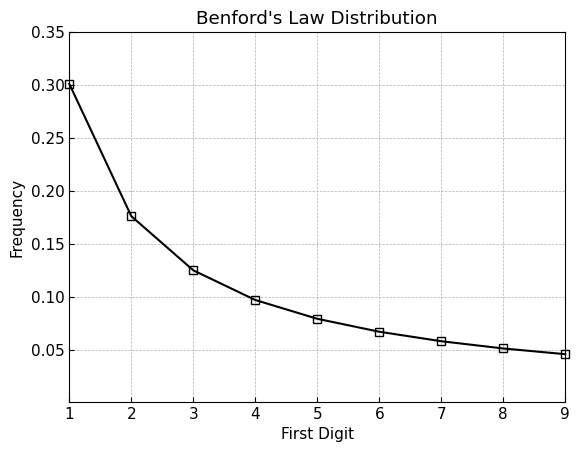

In [1]:
# Plot of Benford's Law distribution

import matplotlib.pyplot as plt
import numpy as np

plt.rcParams.update({"font.size": 11})

# Benford's Law distribution
DIGITS = np.arange(1, 10)


def log_benford_func(x, N, q, s):
    return N * np.log10(1 + 1 / (s + np.pow(x, q)))


BENFORD = log_benford_func(DIGITS, 1, 1, 0)

# Plot
plt.margins(0, tight=True)
plt.plot(DIGITS, BENFORD, "s-", color="black", clip_on=False, markerfacecolor="none")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.title("Benford's Law Distribution")
plt.xlabel("First Digit")
plt.ylabel("Frequency")
plt.ylim(0.001, 0.35)
plt.tick_params(direction="in")

In [2]:
# Q factor = 98
N_98 = 4.97227351
q_98 = 1.85334686
s_98 = 6.45064833

BENFORD_98 = log_benford_func(DIGITS, N_98, q_98, s_98)

# Q factor = 75
N_75 = 5.30554254
q_75 = 1.910744
s_75 = 6.85574919

BENFORD_75 = log_benford_func(DIGITS, N_75, q_75, s_75)

## Dataset

For this notebook, we will be using a dataset that closely matches the one stated in the paper "Benford's law applied to digital forensic analysis" by Fernandes et al (2023):

| Name                            |   Fake   |   Real   |
| ------------------------------- | :------: | :------: |
| Columbia Image Splicing Dataset |   180    |   180    |
| COVERAGE dataset                |   100    |   100    |
| CelebA-HQ dataset               |    -     |   8600   |
| This person does not exist      |   120    |    -     |
| 100K-Faces-HQ Datset            |   8600   |    -     |
| Flickr-Faces-HQ Dataset         |          |   120    |
|                                 |          |          |
| **Total**                       | **9000** | **9000** |

However, due to the paper's lack of clear details on the methodology (for example, the CelebA-HQ dataset consists of 30,000 images, but only 8,600 were used), the dataset recreated is done to the best of my abilities.


In [40]:
import os

dir_fake = ["../../dataset/fake/100k"]
dir_real = ["../../dataset/real/celeba-hq"]


def gather_files(dirs: list[str]) -> list[str]:
    """Collect all file paths, filter invalid files and return a list of valid file paths."""
    return [
        os.path.join(subdir, file)
        for dir in dirs
        for subdir, _, files in os.walk(dir)
        for file in files
        if os.path.isfile(os.path.join(subdir, file))
    ]


fake_files = gather_files(dir_fake)[:1000]
real_files = gather_files(dir_real)[:1000]

print(f"Fake files: {len(fake_files)}, Real files: {len(real_files)}")

Fake files: 1000, Real files: 1000


## Discrete Cosine Transform (DCT)

The methodology is as follows:

1. Read the image and convert it to grayscale to get its luminance channel.
2. Divide the image to non-overlapping 8x8 blocks.
3. Apply DCT to each block.
4. Extract the DCT coefficients and their first digits.
5. Accumulate the first digits of the DCT coefficients, and discard the 0 coefficients.
6. Use hypothesis testing to determine if the image is real or fake wrt Benford's Law.


In [41]:
from functools import partial
from multiprocessing import Pool, cpu_count

import cv2
from tqdm import tqdm

import scipy as sp


def zigzag(matrix: np.ndarray) -> np.ndarray:
    """
    Zigzag traversal of a 2D matrix to convert a 2D array to a 1D array.
    """
    rows, cols = matrix.shape
    result = []
    for diag in range(rows + cols - 1):
        if diag % 2 == 0:
            # Even diagonal: traverse from bottom-left to top-right
            start_row = min(diag, rows - 1)
            start_col = diag - start_row
            while start_row >= 0 and start_col < cols:
                result.append(matrix[start_row, start_col])
                start_row -= 1
                start_col += 1
        else:
            # Odd diagonal: traverse from top-right to bottom-left
            start_col = min(diag, cols - 1)
            start_row = diag - start_col
            while start_col >= 0 and start_row < rows:
                result.append(matrix[start_row, start_col])
                start_row += 1
                start_col -= 1
    return np.array(result)


def first_digit(x: float) -> int:
    x = abs(x)  # Ensure the number is positive
    while x >= 10:
        x //= 10  # Divide by 10 until it's less than 10
    while x < 1 and x > 0:
        x *= 10  # Multiply by 10 until it's at least 1
    return int(x)  # Return the integer part


def dct(filename: str, block_size: int = 8) -> np.ndarray:
    # Read Luminance of image
    try:
        img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    except Exception as e:
        print(f"Error reading {filename}: {e}")

    height, width = img.shape

    # Shift the matrix values from [0, 255] to [-128, 127]
    img = np.array(img, dtype=np.int16) - 128

    # crop the image to the nearest multiple of BLOCK_SIZE
    height = height - height % block_size
    width = width - width % block_size

    img = img[:height, :width]

    # chop up the matrix into blocks as defined by BLOCK_SIZE
    blocks = img.reshape(
        height // block_size, block_size, width // block_size, block_size
    ).swapaxes(1, 2)

    # Perform 2D DCT to each block and flatten the blocks from 3D to 1D
    dct_blocks = np.array(
        [
            [
                zigzag(sp.fft.dctn(blocks[i, j], norm="ortho"))
                for j in range(blocks.shape[1])
            ]
            for i in range(blocks.shape[0])
        ],
    ).flatten()

    # Extract the first digits of the DCT coefficients
    first_digits = np.array([first_digit(x) for x in dct_blocks if x != 0])

    # Calculate the first digit occurences for each digit
    occurrences = np.array(
        [np.sum(first_digits == i) for i in range(10)], dtype=np.uint32
    )

    # Remove the first column (0) from the occurrences
    occurrences = occurrences[1:]

    # Calculate the probabilities of each digit
    total_sum = np.sum(occurrences)
    return occurrences / total_sum


def multithread_dct(filenames: list[str], **kwargs) -> list[list[float]]:
    with Pool(processes=cpu_count()) as pool:
        results = list(
            tqdm(
                pool.imap(partial(dct, **kwargs), filenames),
                total=len(filenames),
                desc="Performing Feature Extraction",
            )
        )
    return results


In [42]:
from icecream import ic


def process_file(filename):
    try:
        return dct(filename)
    except Exception as e:
        print(f"Error processing {filename}: {e}")
        return None


with Pool() as pool:
    probs_fake = list(
        tqdm(
            pool.imap(process_file, fake_files),
            total=len(fake_files),
            desc="Processing files",
        )
    )

with Pool() as pool:
    probs_real = list(
        tqdm(
            pool.imap(process_file, real_files),
            total=len(real_files),
            desc="Processing files",
        )
    )

# Remove None results if any files failed to process
probs_fake = [result for result in probs_fake if result is not None]
probs_real = [result for result in probs_real if result is not None]

ic(len(probs_fake), len(probs_real))

Processing files: 100%|██████████| 1000/1000 [06:40<00:00,  2.49it/s]
ic| len(probs_fake): 1000, len(probs_real): 1000


(1000, 1000)

In [15]:
label_total_fake = np.full(len(probs_fake), True)
label_total_real = np.full(len(probs_real), False)

probs = probs_fake + probs_real
labels = np.concatenate((label_total_fake, label_total_real))

## Hypothesis Testing

Here, we will do hypothesis testing to determine whether a picture is considered fake or not. We will use the Pearson's Correlation Coefficient of the distribution of the image's first digits count with respect to the Benford's Law.

If the absolute value of the Pearson's Correlation Coefficient $\rho$ is close to 1, then the first digit distribution follows Benford's Law, and we can consider the image as real. Otherwise, if the absolute value of the Pearson's Correlation Coefficient is not equal to 1, then the first digit distribution does not follow Benford's Law, and we can consider the image as fake.

$$H_0: \rho = 1 \text{(Real Image)}$$
$$H_1: \rho \neq 1 \text{(Fake Image)}$$


In [16]:
import scipy.stats as stats


def test_goodness_of_fit(
    threshold: int, probs: list[float], benford_distribution: list[float]
) -> bool:
    goodness_of_fit = stats.pearsonr(probs, benford_distribution)

    return abs(goodness_of_fit[0]) < threshold


In [ ]:
from wand.image import Image


def jpeg_check(file):
    with Image(filename=file) as i:
        if i.format == "JPEG":
            return i.compression_quality
        else:
            return None


jpeg_check("../../dataset/fake/coverage/1t.tif")

ic| jpeg_check("../../dataset/fake/coverage/1t.tif"): None


In [ ]:
# Print the table using pandas Dataframe
import sklearn.metrics as metrics

THRESHOLD = [0.999, 0.998, 0.997, 0.996, 0.995]

for thr in THRESHOLD:

    def test_goodness_of_fit_fake(probs):
        return test_goodness_of_fit(thr, probs, BENFORD_75)

    def test_goodness_of_fit_real(probs):
        return test_goodness_of_fit(thr, probs, BENFORD_98)

    with Pool() as pool:
        fake_results = list(pool.imap(test_goodness_of_fit_fake, probs_fake))

    with Pool() as pool:
        real_results = list(pool.imap(test_goodness_of_fit_real, probs_real))

    ic(thr)
    ic(fake_results.count(True), len(fake_results))
    ic(real_results.count(False), len(real_results))

    # Calculate performance metrics


ic| thr: 0.999
ic| fake_results.count(True): 200, len(fake_results): 200
ic| real_results.count(False): 0, len(real_results): 200
ic| thr: 0.998
ic| fake_results.count(True): 200, len(fake_results): 200
ic| real_results.count(False): 7, len(real_results): 200
ic| thr: 0.997
ic| fake_results.count(True): 196, len(fake_results): 200
ic| real_results.count(False): 111, len(real_results): 200
ic| thr: 0.996
ic| fake_results.count(True): 186, len(fake_results): 200
ic| real_results.count(False): 173, len(real_results): 200
ic| thr: 0.995
ic| fake_results.count(True): 166, len(fake_results): 200
ic| real_results.count(False): 190, len(real_results): 200
